In [1]:
#1. soru
import tensorflow as tf
from tensorflow.keras import models, layers
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [2]:
dataset_path= "/content/drive/MyDrive/deepproject/Banana"
dataset = tf.keras.preprocessing.image_dataset_from_directory(dataset_path)

Found 13498 files belonging to 4 classes.


In [3]:
labels = dataset.class_names
labels

['overripe', 'ripe', 'rotten', 'unripe']

In [4]:
img_size = (64, 64)

In [5]:
data = []
for label in labels:
    label_path = os.path.join(dataset_path, label)
    for img_file in os.listdir(label_path):
        img_path = os.path.join(label_path, img_file)      #görüntünün tam yolu
        img = load_img(img_path, target_size=img_size)    # Görüntüyü belirlenen boyuta yüklüyoruz.
        img_array = img_to_array(img)                    # Yüklenen görüntüyü bir diziye dönüştürüyoruz.
        data.append((img_array, label))

In [6]:
X = np.array([item[0] for item in data])
y = np.array([labels.index(item[1]) for item in data])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)# Veri kümesinin yüzde 20'sini test kümesi olarak ayarlar

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)# Eğitim veri kümesinin %10'u doğrulama veri kümesi olarak ayrılıyor.


In [9]:
from tensorflow.keras.optimizers import Adam

def build_model(hp):
      # Sequential modelini başlatıyoruz.
    model = Sequential()

    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    # Üçüncü konvolüsyonel katmanı ekliyoruz.
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    # Düzleştirme katmanı.
    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, default=0.5)))
    model.add(BatchNormalization())

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, default=0.5)))
    model.add(BatchNormalization())

    # Çıkış katmanını ekliyoruz (4 sınıflı softmax).
    model.add(Dense(4, activation='softmax'))

    # Optimizasyon algoritmasını belirliyoruz (Adam optimizer).
    optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3))

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [22]:

from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='hyperparameter_opt',
    project_name='cnn_tuner'
)



<ipython-input-22-029c45b281d1>:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [23]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,                #genel olarak görüntü arttırma parametreleri belirlenir.
    height_shift_range=0.2,
    horizontal_flip=True
)

In [24]:

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Modeli eğitim verisi üzerinde, ImageDataGenerator kullanarak ve hiperparametre optimizasyonu yaparak eğitiyoruz.
tuner.search(datagen.flow(X_train, y_train, batch_size=32), steps_per_epoch=len(X_train) / 32,
             epochs=10, validation_data=(X_val, y_val), callbacks=[early_stopping])

Trial 5 Complete [00h 32m 13s]
val_accuracy: 0.8722222447395325

Best val_accuracy So Far: 0.9259259104728699
Total elapsed time: 02h 09m 20s


In [25]:

best_hps = tuner.oracle.get_best_trials(1)[0].hyperparameters

print("En iyi hiperparametreler:")
for key, value in best_hps.values.items():
    print(f"{key}: {value}")

En iyi hiperparametreler:
dropout_1: 0.22070191476553247
dropout_2: 0.2969192506620009
learning_rate: 0.007676397141103724


In [26]:

best_trial = tuner.oracle.get_best_trials(1)[0]

best_model = build_model(best_trial.hyperparameters)

best_model.compile(optimizer=Adam(learning_rate=best_trial.hyperparameters.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

history = best_model.fit(datagen.flow(X_train, y_train, batch_size=32),
                         steps_per_epoch=len(X_train) / 32,
                         epochs=10,
                         validation_data=(X_val, y_val))

evaluation = best_model.evaluate(X_test, y_test)
print("Test verisi üzerinde modelin performansı:", evaluation)

Epoch 1/10
303/303 [==============================] - 213s 686ms/step - loss: 0.6572 - accuracy: 0.7520 - val_loss: 2.3382 - val_accuracy: 0.5222
Epoch 2/10
303/303 [==============================] - 208s 684ms/step - loss: 0.4546 - accuracy: 0.8243 - val_loss: 1.1164 - val_accuracy: 0.6019
Epoch 3/10
303/303 [==============================] - 211s 696ms/step - loss: 0.3836 - accuracy: 0.8532 - val_loss: 0.6851 - val_accuracy: 0.7657
Epoch 4/10
303/303 [==============================] - 206s 678ms/step - loss: 0.3356 - accuracy: 0.8760 - val_loss: 1.4630 - val_accuracy: 0.5565
Epoch 5/10
303/303 [==============================] - 207s 681ms/step - loss: 0.3039 - accuracy: 0.8901 - val_loss: 1.3491 - val_accuracy: 0.7204
Epoch 6/10
303/303 [==============================] - 207s 682ms/step - loss: 0.2842 - accuracy: 0.9005 - val_loss: 1.3723 - val_accuracy: 0.6676
Epoch 7/10
303/303 [==============================] - 203s 668ms/step - loss: 0.2866 - accuracy: 0.8958 - val_loss: 0.1938 -

In [27]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

85/85 [==============================] - 16s 187ms/step
Test Accuracy: 0.8178
Precision: 0.8716
Recall: 0.8178
F1 Score: 0.8185
Confusion Matrix:


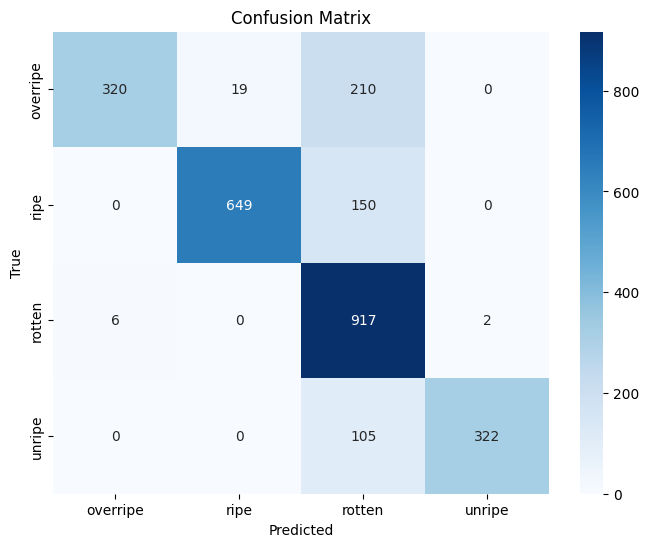

Classification Report:              precision    recall  f1-score   support

    overripe       0.98      0.58      0.73       549
        ripe       0.97      0.81      0.88       799
      rotten       0.66      0.99      0.79       925
      unripe       0.99      0.75      0.86       427

    accuracy                           0.82      2700
   macro avg       0.90      0.79      0.82      2700
weighted avg       0.87      0.82      0.82      2700



In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')
precision = precision_score(y_test, y_pred, average='weighted')
print(f'Precision: {precision:.4f}')
recall = recall_score(y_test, y_pred, average='weighted')
print(f'Recall: {recall:.4f}')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1 Score: {f1:.4f}')
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
class_report = classification_report(y_test, y_pred, target_names=labels)
print('Classification Report:'+ class_report)


In [29]:
#2. soru
from tensorflow.keras.applications import MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))


9406464/9406464 [==============================] - 0s 0us/step


In [30]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [31]:
for layer in base_model.layers:
    layer.trainable = False # transfer learning) yöntemiyle bir önceden eğitilmiş bir modelin (base_model) katmanlarını dondurmayı amaçlar.

In [32]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [33]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,      #genel olarak görüntü veri arttırma
    height_shift_range=0.2,
    horizontal_flip=True
)

In [34]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
303/303 [==============================] - 48s 142ms/step - loss: 1.1087 - accuracy: 0.5754 - val_loss: 0.8768 - val_accuracy: 0.6426
Epoch 2/10
303/303 [==============================] - 47s 154ms/step - loss: 0.8723 - accuracy: 0.6488 - val_loss: 0.8442 - val_accuracy: 0.6713
Epoch 3/10
303/303 [==============================] - 44s 144ms/step - loss: 0.8349 - accuracy: 0.6622 - val_loss: 0.8892 - val_accuracy: 0.6574
Epoch 4/10
303/303 [==============================] - 44s 146ms/step - loss: 0.8182 - accuracy: 0.6738 - val_loss: 0.8044 - val_accuracy: 0.6898
Epoch 5/10
303/303 [==============================] - 44s 146ms/step - loss: 0.7966 - accuracy: 0.6764 - val_loss: 0.8351 - val_accuracy: 0.6565
Epoch 6/10
303/303 [==============================] - 44s 144ms/step - loss: 0.7922 - accuracy: 0.6819 - val_loss: 0.8767 - val_accuracy: 0.6657
Epoch 7/10
303/303 [==============================] - 43s 141ms/step - loss: 0.7674 - accuracy: 0.6910 - val_loss: 0.8102 - val_ac

In [35]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

85/85 [==============================] - 10s 97ms/step
Test Accuracy: 0.7189
Precision: 0.7218
Recall: 0.7189
F1 Score: 0.7197
Confusion Matrix:


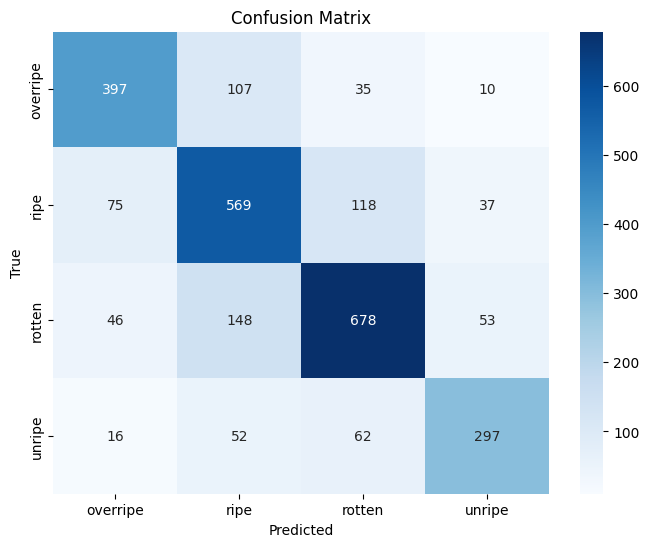

Classification Report:
              precision    recall  f1-score   support

    overripe       0.74      0.72      0.73       549
        ripe       0.65      0.71      0.68       799
      rotten       0.76      0.73      0.75       925
      unripe       0.75      0.70      0.72       427

    accuracy                           0.72      2700
   macro avg       0.73      0.72      0.72      2700
weighted avg       0.72      0.72      0.72      2700



In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
class_report = classification_report(y_test, y_pred, target_names=labels)
print('Classification Report:')
print(class_report)

In [37]:
#3.soru
from keras.applications.efficientnet import EfficientNetB0

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

16705208/16705208 [==============================] - 0s 0us/step


In [38]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [39]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [40]:
from tensorflow.keras.utils import to_categorical
y_train_encoded = to_categorical(y_train, num_classes=4)
y_val_encoded = to_categorical(y_val, num_classes=4)

In [41]:
history = model.fit(datagen.flow(X_train, y_train_encoded, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=10, validation_data=(X_val, y_val_encoded))

Epoch 1/10
303/303 [==============================] - 275s 810ms/step - loss: 0.3646 - accuracy: 0.8876 - val_loss: 0.2188 - val_accuracy: 0.9296
Epoch 2/10
303/303 [==============================] - 252s 830ms/step - loss: 0.1838 - accuracy: 0.9398 - val_loss: 0.2275 - val_accuracy: 0.9380
Epoch 3/10
303/303 [==============================] - 250s 823ms/step - loss: 0.1473 - accuracy: 0.9541 - val_loss: 0.1320 - val_accuracy: 0.9509
Epoch 4/10
303/303 [==============================] - 250s 823ms/step - loss: 0.1292 - accuracy: 0.9602 - val_loss: 0.1260 - val_accuracy: 0.9611
Epoch 5/10
303/303 [==============================] - 244s 803ms/step - loss: 0.1122 - accuracy: 0.9629 - val_loss: 0.1598 - val_accuracy: 0.9602
Epoch 6/10
303/303 [==============================] - 247s 813ms/step - loss: 0.1162 - accuracy: 0.9629 - val_loss: 0.0987 - val_accuracy: 0.9704
Epoch 7/10
303/303 [==============================] - 241s 794ms/step - loss: 0.0973 - accuracy: 0.9668 - val_loss: 0.0834 -

In [42]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

85/85 [==============================] - 19s 187ms/step
Test Accuracy: 0.9807
Precision: 0.9808
Recall: 0.9807
F1 Score: 0.9808
Confusion Matrix:


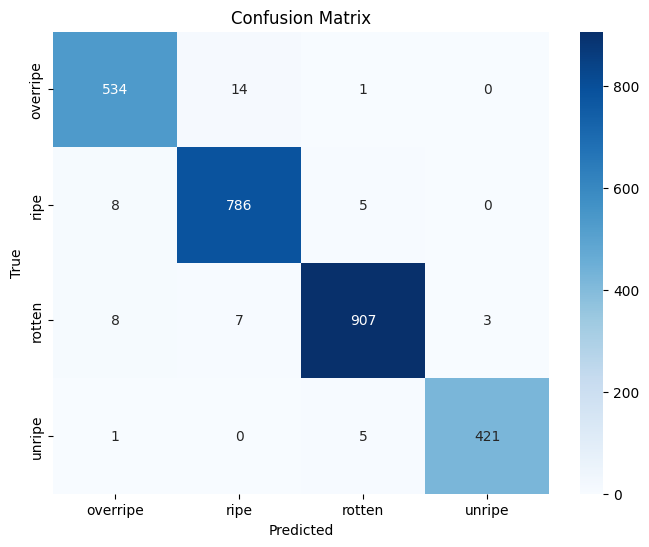

Classification Report:
              precision    recall  f1-score   support

    overripe       0.97      0.97      0.97       549
        ripe       0.97      0.98      0.98       799
      rotten       0.99      0.98      0.98       925
      unripe       0.99      0.99      0.99       427

    accuracy                           0.98      2700
   macro avg       0.98      0.98      0.98      2700
weighted avg       0.98      0.98      0.98      2700



In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
class_report = classification_report(y_test, y_pred, target_names=labels)
print('Classification Report:')
print(class_report)